# Unimodal Varying Request Rate and Average Requested Distance

Varying $\nu$ and $\langle d\rangle$

Efficiency should be constant for lines with
$$\nu\cdot\langle d\rangle = \mathrm{const}$$

-> Expect hyperbolas in Efficiency

In [64]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from HelperFunctions import *
from PtOccupancyFunctions import *
import scipy.integrate
import pprint
from FindDataFunctions import *
from scipy.optimize import curve_fit

In [35]:
path = "/scratch01.local/hheuer/matsim-bimodal/scenarios/fine_grid/unimodal/output/VaryNuMeanDist3AlphaReally900Beta/"

In [36]:
ndrt = "1000"
uni_dirs = getDirs(path, ["reqs", "dist", "frac_comm_orig_dest", "drt", "unimodal"], [None, None, None, ndrt, None])
display(uni_dirs)

[[90000.0,
  1400.0,
  0.0,
  1000.0,
  {'root': '/scratch01.local/hheuer/matsim-bimodal/scenarios/fine_grid/unimodal/output/VaryNuMeanDist3AlphaReally900Beta/90000reqs/1400dist/0frac_comm_orig_dest/1000drt/unimodal',
   'ph_modestats': '/scratch01.local/hheuer/matsim-bimodal/scenarios/fine_grid/unimodal/output/VaryNuMeanDist3AlphaReally900Beta/90000reqs/1400dist/0frac_comm_orig_dest/1000drt/unimodal/ph_modestats.txt',
   'persons': '/scratch01.local/hheuer/matsim-bimodal/scenarios/fine_grid/unimodal/output/VaryNuMeanDist3AlphaReally900Beta/90000reqs/1400dist/0frac_comm_orig_dest/1000drt/unimodal/output_persons.csv.gz',
   'pkm_modestats': '/scratch01.local/hheuer/matsim-bimodal/scenarios/fine_grid/unimodal/output/VaryNuMeanDist3AlphaReally900Beta/90000reqs/1400dist/0frac_comm_orig_dest/1000drt/unimodal/pkm_modestats.txt',
   'trip_success': '/scratch01.local/hheuer/matsim-bimodal/scenarios/fine_grid/unimodal/output/VaryNuMeanDist3AlphaReally900Beta/90000reqs/1400dist/0frac_comm_orig_d

In [80]:
saved_path = os.path.join(path, f"saved_{ndrt}drt.pkl")
if os.path.isfile(saved_path):
    df = pd.read_pickle(saved_path)
else:
    cols = ["reqs", "mean_dist", "occupancy", "occupancy_non_idling", "detour", "servability", "req_mean_dist", "drt_wait_time",
        "drt_wait_time_normalized", "drt_distance", "cummulative_dist_drt",
        "cummulative_dist_drt_unshared", "pkm_drt", "idling_frac"]
    
    df = pd.DataFrame(np.full((len(uni_dirs),len(cols)), np.nan), columns=cols)

    for i,entry in enumerate(uni_dirs):
        print(*entry[:-1])
        dic = entry[-1]
        row = df.iloc[i]
#         try:
        row.loc["reqs"] = entry[0]
        row.loc["mean_dist"] = entry[1]
        row.loc["occupancy"], row.loc["idling_frac"] = getDrtOccupandyAndStandingFrac(dic, False, True)
        row.loc["occupancy_non_idling"], _ = getDrtOccupandyAndStandingFrac(dic, False, False)
        df_detour = getDrtDetours(dic)
        row.loc["detour"] = df_detour["distanceDetour"].mean()
        trip_succ = getTripSuccess(dic)
        row.loc["servability"] = len(trip_succ[trip_succ["tripSuccess"]]) / len(trip_succ)
        df_persons = getPersons(dic)
        row.loc["req_mean_dist"] = df_persons["mean_dist"].mean()
        drt_trips, drt_trips_perperson = getDrtTrips(dic)
        row.loc["drt_wait_time"] = drt_trips_perperson["waitTime"].mean()
        row.loc["cummulative_dist_drt"] = getDrtVehicleDistances(dic).sum()
        row.loc["cummulative_dist_drt_unshared"] = drt_trips["direcTravelDistance_m"].sum()
        df_detour = df_detour.set_index("person")
        row.loc["drt_wait_time_normalized"] = (drt_trips_perperson["waitTime"]/df_detour["unsharedTime"]).mean()
        row.loc["drt_distance"] = drt_trips_perperson["travelDistance_m"].mean()
        _, row.loc["pkm_drt"] = getModeStats(dic, [], ["drt"])
#         except KeyError:
#             print("KeyError")
        print("-----")
    df.to_pickle(saved_path)

In [81]:
v_drt = 30/3.6

effective_dist_mapping = df[["mean_dist","req_mean_dist"]].groupby("mean_dist").mean()["req_mean_dist"]
df["req_mean_dist_av"] = df["mean_dist"].map(effective_dist_mapping)
df["efficiency1"] = df["cummulative_dist_drt_unshared"]/df["cummulative_dist_drt"]
df["efficiency2"] = df["occupancy_non_idling"]/df["detour"]
df["pbusy"] = 1 - df["idling_frac"]
data = df.pivot(index="reqs", columns="req_mean_dist_av", values=["servability", "drt_wait_time",
                                                       "drt_wait_time_normalized" ,"drt_distance",
                                                       "req_mean_dist", "cummulative_dist_drt",
                                                      "cummulative_dist_drt_unshared", "pkm_drt",
                                                       "occupancy", "occupancy_non_idling", "detour",
                                                        "idling_frac"])
# df["drt_wait_time"] /= df["req_mean_dist"].mean()/v_drt

In [82]:
mean_dist = df.groupby

<IPython.core.display.Javascript object>


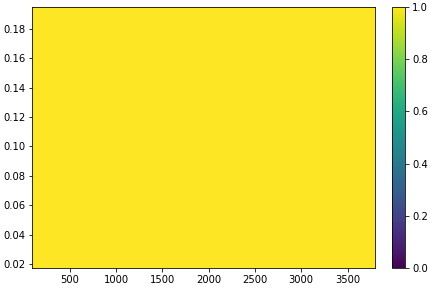

In [83]:
fig, ax = plt.subplots(constrained_layout=True)

sim_timescale = 9*3600 # T_sim [s]
timescale = 10000/(30/3.6) # L/v_drt

# Z = data["cummulative_dist_drt_unshared"]/data["cummulative_dist_drt"]
Z = data["servability"]
x = Z.index.to_numpy()/sim_timescale*timescale
y = Z.columns.to_numpy()/10000
X,Y = np.meshgrid(x, y, indexing='ij')

im = ax.pcolormesh(X,Y,Z.to_numpy(), shading="auto", vmin=0, vmax=1)
fig.colorbar(im)

plt.show()

$$\Lambda=\frac{\nu E D^3}{v}$$

In [84]:
def sigmoid(x,a,k):
    return a/(1+np.exp(-k*x))-a/2

def log(x,a,b):
    return a*np.log(b*x)

def power(x,b):
    return x**b

<IPython.core.display.Javascript object>


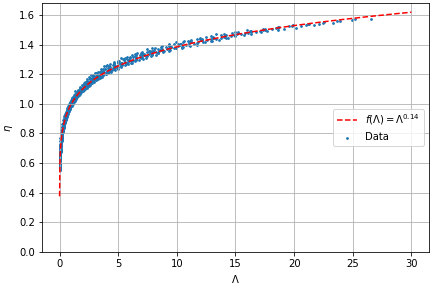

[0.14163321]


In [85]:
%matplotlib notebook
L=10000
nu = 1/(3600*9)
df["E"] = df["reqs"]/L**2
df["B"] = int(ndrt)/L**2
df["Λ"] = nu*df["E"]*df["req_mean_dist"]**3/v_drt

# df_plot = df[df["mean_dist"] == 3000]
df_plot = df[:]

#TODO nur frequency/distance variieren, plot theory form

fig, ax = plt.subplots(constrained_layout=True)

ax.scatter(df_plot["Λ"], df_plot["efficiency1"], s=3, label="Data")
# ax.scatter(df["Λ"], df["detour"], s=3)
# ax.scatter(nu*df["reqs"]*df["mean_dist"], df["efficiency2"], s=3)
# ax.scatter(df["Λ"], df["Λ"]/(df["B"]*df["mean_dist"]**2)*1/df["pbusy"], s=3)
# ax.scatter(df["Λ"]/(df["mean_dist"]**2*df["B"])/df["pbusy"], df["efficiency2"], s=3)
popt, pcov = curve_fit(power, df_plot["Λ"], df_plot["efficiency1"])
print(popt)
x = np.linspace(0.001,30,1000)
# ax.plot(x, log(x,*popt), color="red", ls="--")
# ax.plot(x, power(x,*popt), color="red", ls="--", label=rf"${round(popt[0],2)}\Lambda^{{{round(popt[1],2)}}}$")
ax.plot(x, power(x,*popt), color="red", ls="--", label=rf"$f(\Lambda)=\Lambda^{{{round(popt[0],2)}}}$")
# ax.plot(x, 2.3*x**0.1)
# ax.set_xlim(-10,None)
ax.set_ylim(0,None)
# ax.set_xlabel(r"$D$")
ax.set_xlabel(r"$\Lambda$")
ax.set_ylabel(r"$\eta$")
ax.legend(loc="center right")
ax.grid()

# ax.set_xscale("log")
# ax.set_yscale("log")
# fig.savefig("Figures/DeltaOfLambdaUnimodal1000drtlog.jpg", dpi=600)

# 800drt -> popt=[0.93510452 0.11505979]
# 1000drt -> popt=[0.94151881 0.11510554]
# 2000drt -> [0.95831991 0.11305549]
# 500drt -> [0.92548124 0.11273381] (p_served !~ 1)

plt.show()

[0.39803362 0.3114498 ]


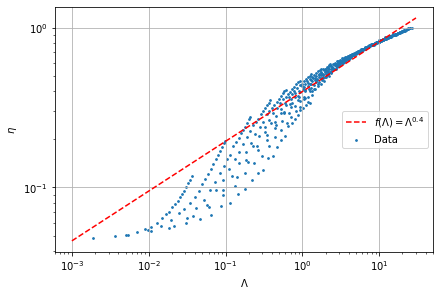

In [111]:
%matplotlib inline
df_plot = df[:]

fig, ax = plt.subplots(constrained_layout=True)

power = lambda x, a, b: a*x**b

drt_wait_time_renorm = df_plot["drt_wait_time"]/df_plot["drt_wait_time"].max() 

ax.scatter(df_plot["Λ"], drt_wait_time_renorm, s=3, label="Data")
popt, pcov = curve_fit(power, df_plot["Λ"], drt_wait_time_renorm)#, p0=[0.48, 0.25])
print(popt)

x = np.linspace(0.001,30,1000)
ax.plot(x, power(x,*popt), color="red", ls="--", label=rf"$f(\Lambda)=\Lambda^{{{round(popt[0],2)}}}$")
# ax.set_xlabel(r"$D$")
ax.set_xlabel(r"$\Lambda$")
ax.set_ylabel(r"$\eta$")
ax.legend(loc="center right")
ax.grid()

# ax.set_ylim(0,None)
ax.set_xscale("log")
ax.set_yscale("log")

plt.show()

In [9]:
print(np.unique(df["mean_dist"]))

[ 200.  300.  400.  500.  600.  700.  800.  900. 1000. 1100. 1200. 1300.
 1400. 1500. 1600. 1700. 1800. 1900. 2000. 2100. 2200. 2300. 2400. 2500.
 2600. 2700. 2800. 2900. 3000.]


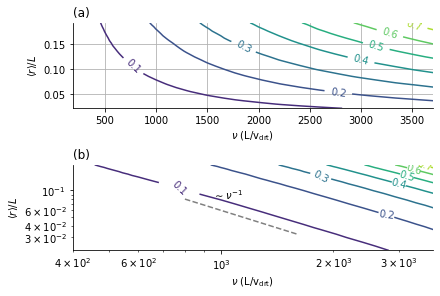

In [7]:
%matplotlib inline

fig, axes = plt.subplots(2,1,constrained_layout=True)
ax = axes[0]

sim_timescale = 9*3600 # T_sim [s]
timescale = 10000/(30/3.6) # L/v_drt

# Z = data["cummulative_dist_drt_unshared"]/data["cummulative_dist_drt"]
# Z = data["occupancy_non_idling"]/data["detour"]
Z = data["occupancy"]/data["detour"]
x = Z.index.to_numpy()/sim_timescale*timescale
y = Z.columns.to_numpy()/10000
X,Y = np.meshgrid(x, y, indexing='ij')

# im = ax.pcolor(X,Y,Z.to_numpy(), shading='auto', linewidth=0)
im = ax.contour(X,Y,Z.to_numpy())
ax.clabel(im, inline=1, fontsize=10)

# im.set_edgecolor('face')
# plt.colorbar(im, label="Efficiency")
ax.set_xlabel(r"$\nu$ (v$_\mathrm{drt}/L$)")
ax.set_ylabel(r"$\langle r\rangle/L$")
# ax.set_xscale("log")
# ax.set_yscale("log")
# fig.suptitle("Efficiency")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.grid()
ax.text(0.0, 1.07, "(a)", transform=ax.transAxes, fontsize="large")

ax = axes[1]

im = ax.contour(X,Y,Z.to_numpy())
ax.clabel(im, inline=1, fontsize=10)

x_vals = np.linspace(800, 1600, 1000)
b = -1.3
a = 0.08/x_vals[0]**b
y_vals = a * x_vals**b
ax.plot(x_vals, y_vals, '--', c="grey")
# ax.text(x_vals[0]+350, y_vals[0]-0.006, r"$\sim \nu^{-1}$")
ax.text(x_vals[0]+150, y_vals[0]-0.001, r"$\sim \nu^{-1}$")
ax.set_xlim(400, None)

# x_vals = np.linspace(300, 700, 1000)
# b = -1/3
# a = 0.050/x_vals[0]**b
# y_vals = a * x_vals**b
# ax.plot(x_vals, y_vals, '--', c="grey")
# ax.text(x_vals[0]+100, y_vals[0]-0.02, r"$\sim \nu^{-1/3}$")

# im.set_edgecolor('face')
# plt.colorbar(im, label="Efficiency")
ax.set_xlabel(r"$\nu$ (v$_\mathrm{drt}/L$)")
ax.set_ylabel(r"$\langle r\rangle/L$")
ax.set_xscale("log")
ax.set_yscale("log")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.text(0.0, 1.07, "(b)", transform=ax.transAxes, fontsize="large")
# ax.grid()
# ax.legend(loc="lower left")

# fig.savefig("Figures/VaryNuAvDistUnimodalEta.jpg", dpi=300)
# fig.savefig("Figures/VaryNuAvDistUnimodalEta.pgf")

plt.show()

<r> =  0.130311061213279


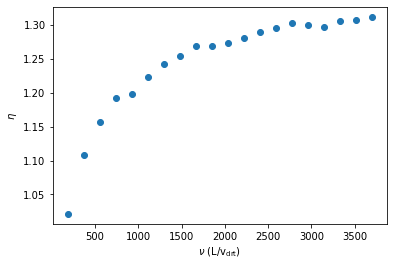

In [30]:
col = 15
nu_range = X[:,col]
av_r = Y[:,col][0]
eff_range = Z.to_numpy()[:,col]
print("<r> = ", av_r)

plt.scatter(nu_range, eff_range)
plt.xlabel(r"$\nu$ (L/v$_\mathrm{drt}$)")
plt.ylabel(r"$\eta$")
plt.show()

nu =  2962.9629629629626


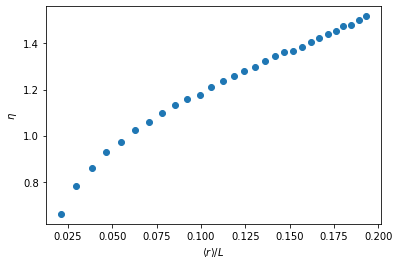

In [34]:
row = 15
nu = X[row,:][0]
r_range = Y[row,:]
eff_range = Z.to_numpy()[row,:]
print("nu = ", nu)

plt.scatter(r_range, eff_range)
plt.xlabel(r"$\langle r\rangle/L$")
plt.ylabel(r"$\eta$")

plt.show()